In [10]:
import os
import sys
import time
import pickle

from functools import partial

import pandas as pd
import numpy as np

from multiprocessing import Pool

from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split

from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, threshold_adaptive

from script.image import load_train_gray_jpg_120
from script.image import load_train_color_224

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
print("Tensorflow is installed and is version: ",  tf.__version__)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Tensorflow is installed and is version:  1.3.0


#### Load the labels

In [2]:
labels_df = pd.read_csv('labels.csv')
print(labels_df.shape)

(10222, 2)


In [3]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
breeds = labels_df.breed.unique()
print('Total of %d unique breeds' % len(breeds))
print('-------------------------')
print(breeds)

Total of 120 unique breeds
-------------------------
['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 'cairn' 'affenpinscher'
 'labrador_retriever' 'ibizan_hound' 'english_setter' 'weimaraner'
 'giant_schnauzer' 'groenendael' 'dhole' 'toy_poodle' 'border_terrier'
 'tibetan_terrier' 'norwegian_elkhound' 'shih-tzu' 'irish_terrier' 'kuvasz'
 'german_shepherd' 'greater_swiss_mountain_dog' 'basset'
 'australian_terrier' 'schipperke' 'rhodesian_ridgeback' 'irish_setter'
 'appenzeller' 'bloodhound' 'samoyed' 'miniature_schnauzer'
 'brittany_spaniel' 'kelpie' 'papillon' 'border_collie' 'entlebucher'
 'collie' 'malamute' 'welsh_springer_spaniel' 'chihuahua' 'saluki' 'pug'
 '

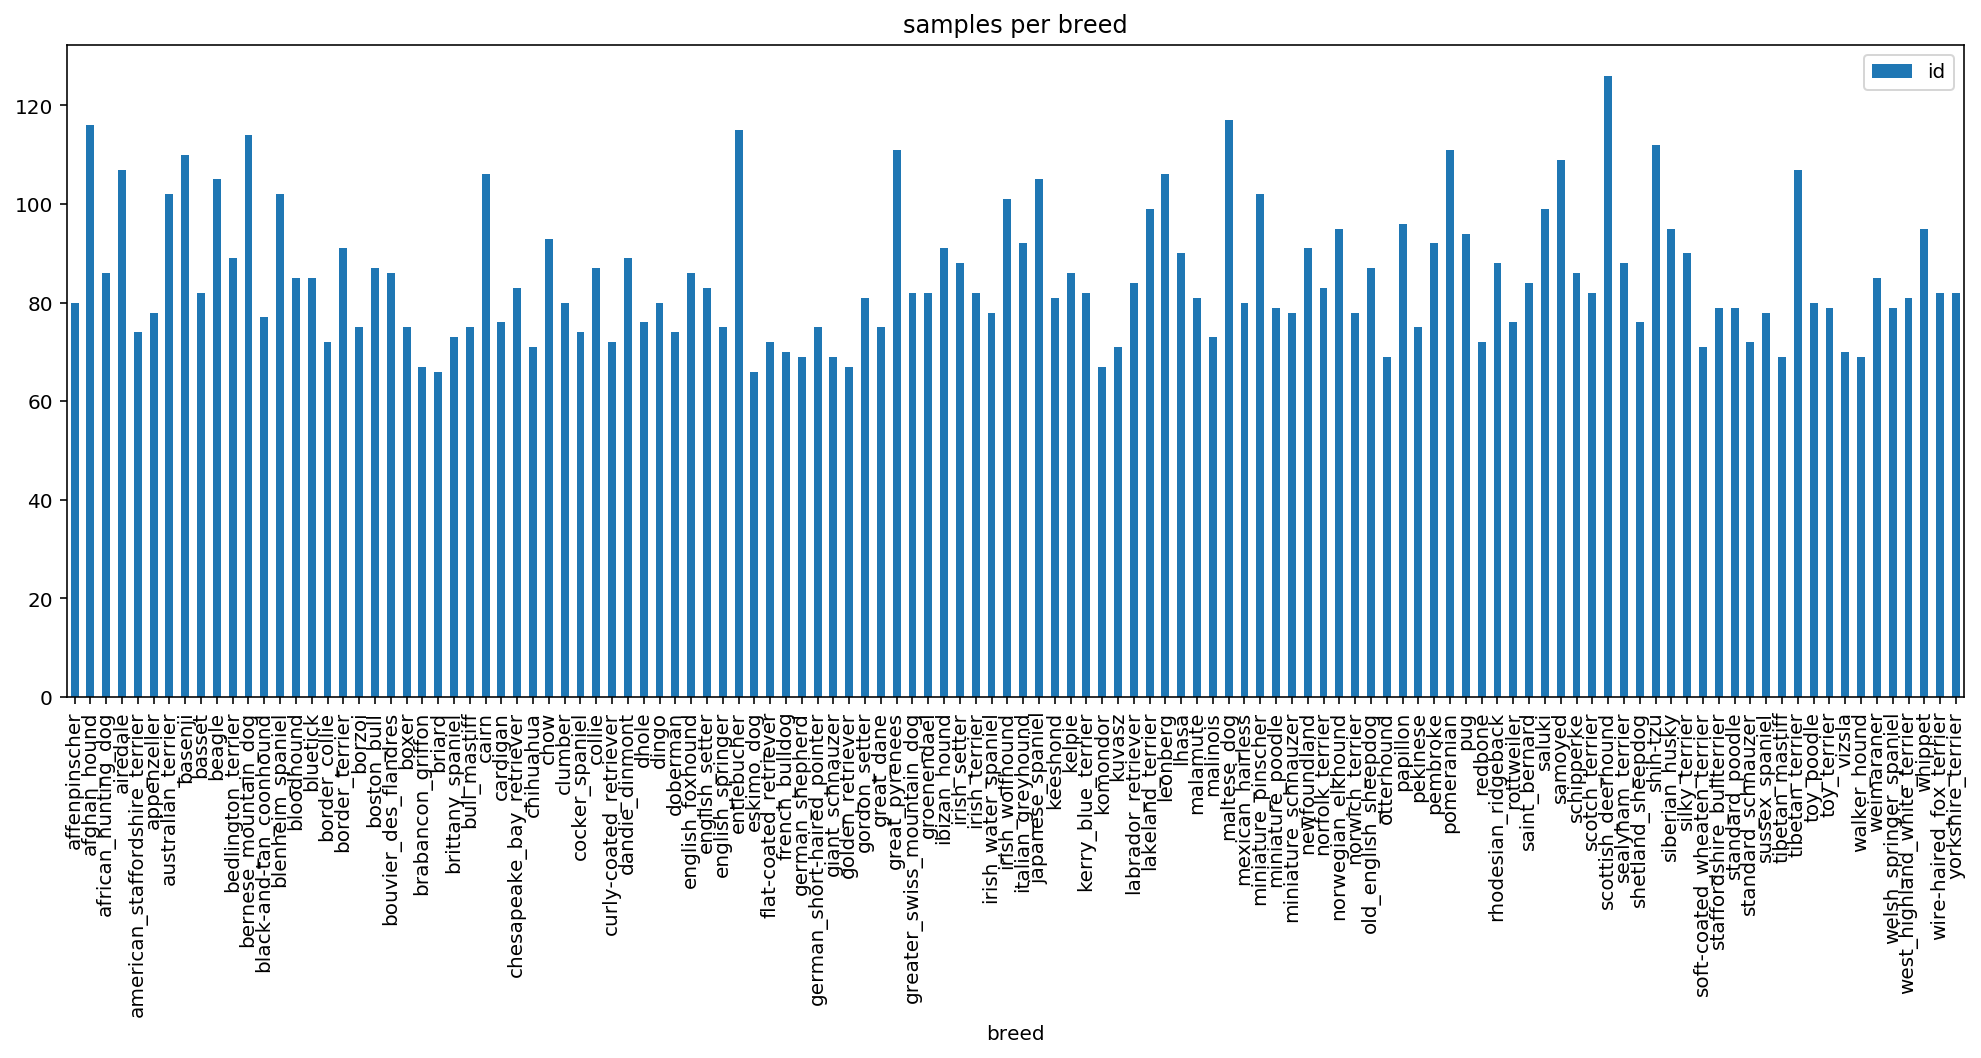

In [5]:
p = labels_df.groupby('breed').count().plot.bar(title='samples per breed', figsize=(17, 6))

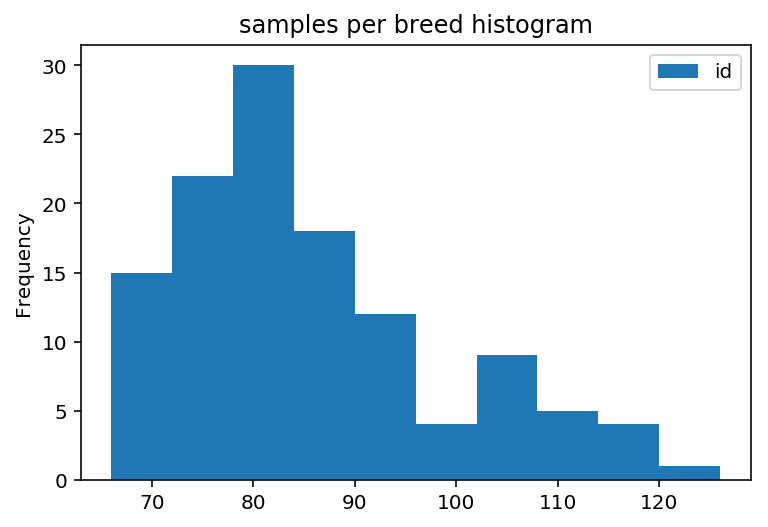

In [6]:
p = labels_df.groupby('breed').count().plot.hist(title='samples per breed histogram')

it looks like we have a balanced dataset, most of the breeds represented by 80 samples with some represented with as many as 120 and some as less as 70.

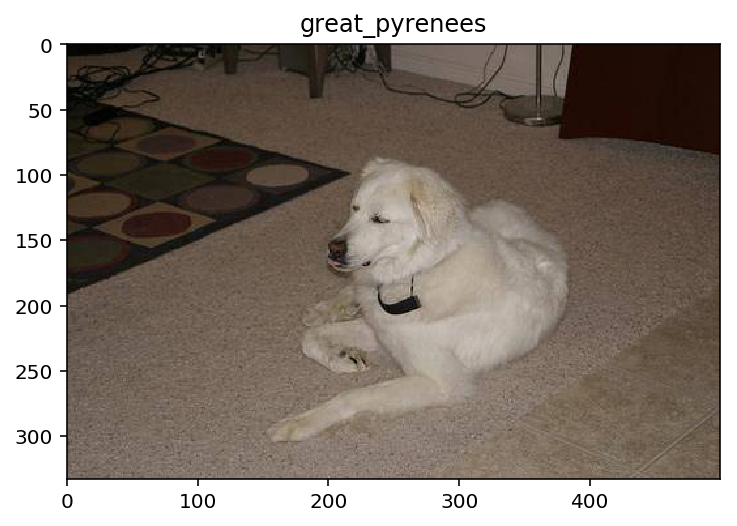

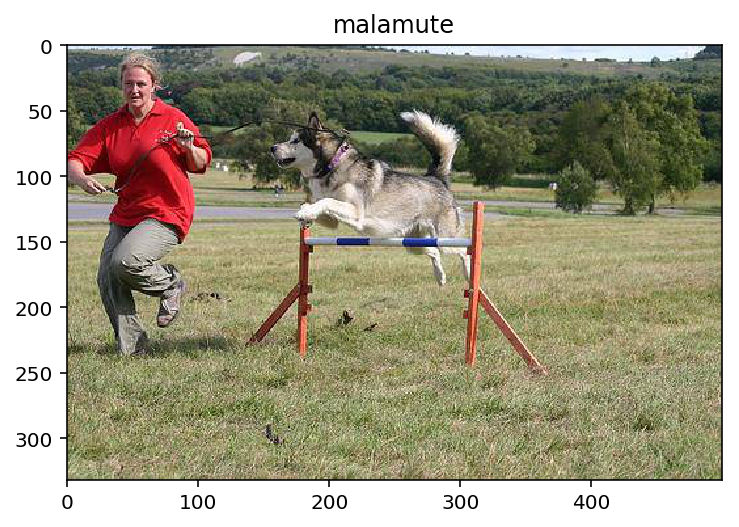

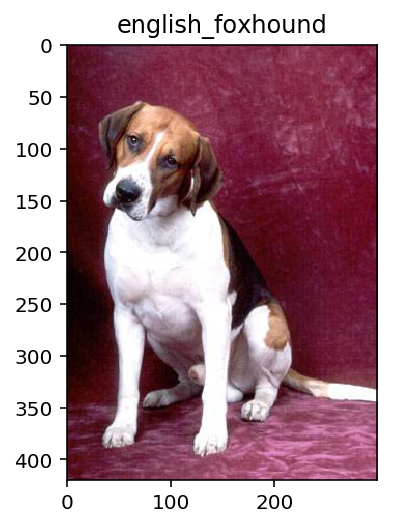

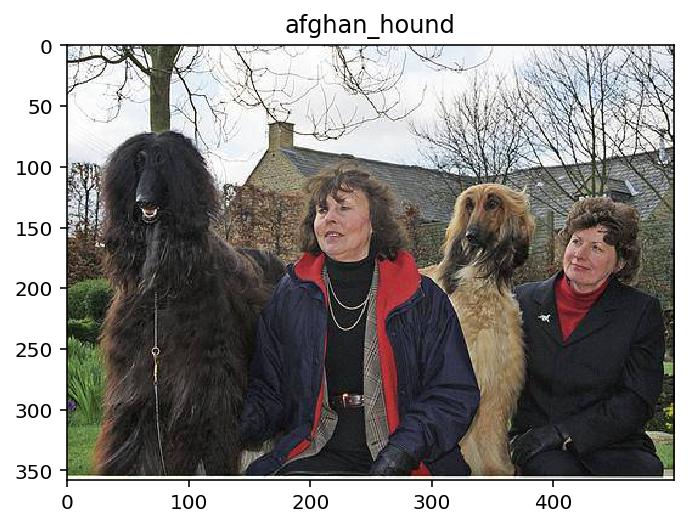

In [7]:
sample_df = labels_df.sample(4, random_state = 102)

for index, row in sample_df.iterrows():
    plt.figure()
    img=mpimg.imread('train/' + row['id'] + '.jpg')
    imgplot=plt.imshow(img)
    plt.title(row['breed'])

1. Some images have multiple dogs.
2. Some images have people and other objects.
3. Some images are different sizes.

#### Can we reduce the image size without loosing too much information?

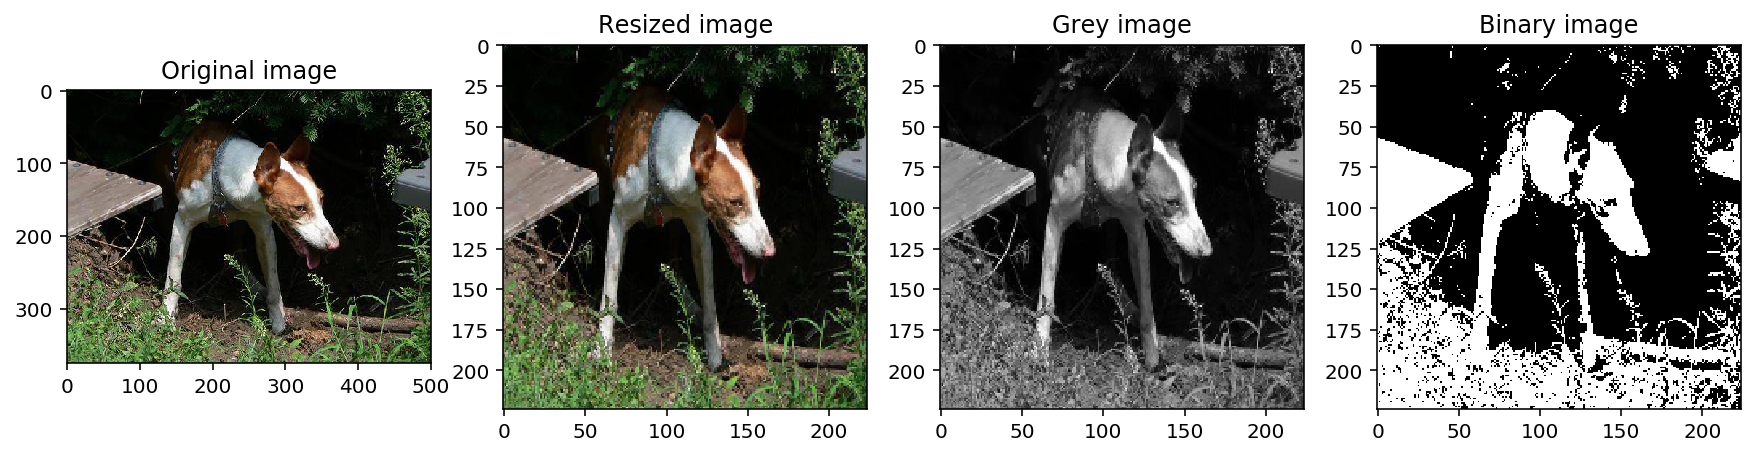

In [8]:
fig, ax= plt.subplots(nrows=1, ncols=4, figsize = (15, 6))

img = io.imread('train/00ddcec076073cc96f82c27bf4548fbc.jpg')
ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title("Original image")

img_resized = resize(img, (224, 224), mode  = 'reflect')
ax[1].imshow(img_resized, cmap=plt.cm.gray)
ax[1].set_title("Resized image")

img_gray = rgb2gray(img_resized)
ax[2].imshow(img_gray, cmap=plt.cm.gray)
ax[2].set_title("Grey image")

thresh = threshold_otsu(img_gray)
binary = img_gray > thresh

ax[3].imshow(binary, cmap=plt.cm.gray)
ax[3].set_title("Binary image")

The grey version looks reasonable, the binary version might be OK to recoginze a dog but probably not a breed.

Load images

In [13]:
with Pool(6) as p:
    rs = p.map_async(load_train_color_224, list(labels_df.id))
    p.close()
    while (True):
        if (rs.ready()): break
        remaining = rs._number_left
        print("Waiting for", remaining, "tasks to complete...")
        time.sleep(10)
print('Finished loading images...')

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 12 tasks to complete...
Waiting for 8 tasks to complete...
Waiting for 5 tasks to complete...
Finished loading images...


In [14]:
features = []
for r in rs.get():
    features.append(r)
features = np.asarray(features)
print('Features shape ', features.shape)

Features shape  (10222, 150528)


In [55]:
labels = label_binarize(labels_df.breed, breeds)
print('Labels shape ', labels.shape)

Labels shape  (10222, 120)


In [56]:
F_train, F_test, l_train, l_test = train_test_split(features, labels, test_size = 0.10, random_state=100)

In [57]:
scaler = StandardScaler()
F_train_scaled = scaler.fit_transform(F_train)
F_test_scaled = scaler.transform(F_test)

In [19]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [20]:
def plot_results(losses, train_acc, valid_acc, test_acc):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_ylabel('loss', color='b')
    ax1.tick_params('y', colors='b')
    ax1.plot(losses, 'b:')

    ax2 = ax1.twinx()
    ax2.set_ylabel('accuracy', color='r')
    ax2.tick_params('y', colors='r')
    ax2.plot(train_acc, 'r--')
    ax2.plot(valid_acc, 'r-')

    plt.title('test accuracy is %f' % test_acc)

    fig.tight_layout()

Base class for a neural network

In [59]:
class NN(object):
    def __init__(self, features_size, labels_size):
        
        self.loss = None
        self.optimizer = None
        self.train_prediction = None
        self.test_prediction = None

        tf.reset_default_graph()
        tf.set_random_seed(100)
        np.random.seed(100)
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            # create input variables
            self.X_train = tf.placeholder(tf.float32, shape=(None, features_size), name="TrainingData")
            self.y_train = tf.placeholder(tf.float32, shape=(None, labels_size), name="TrainingLabels")
            self.X_test  = tf.placeholder(tf.float32, shape=(None, features_size), name="TestingData")
            
    def create_layer(self, kernel_shape, bias_shape):
        weights = tf.get_variable('weights', kernel_shape, tf.float32, tf.truncated_normal_initializer())
        biases = tf.get_variable('biases', bias_shape, tf.float32, tf.constant_initializer(0.0))
        return (weights, biases) 
            
    def run_session(
        self, name, X, y, X_test, y_test, batch_size = 256, num_epochs = 10001, report = 1000, valid_size = 0.1, verbose = 1):

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = valid_size, random_state=100)
        with tf.Session(graph = self.graph) as session:

            tf.global_variables_initializer().run() 

            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("tensorflowlogs", session.graph)
            
            saver = tf.train.Saver()
            
            losses = []
            train_acc = []
            valid_acc = []
            test_acc = 0.0;

            for epoch in range(num_epochs):
                offset = (epoch * batch_size) % (y_train.shape[0] - batch_size)
                X_batch = X_train[offset:(offset + batch_size), :]
                y_batch = y_train[offset:(offset + batch_size), :]

                _, loss_value, predictions = session.run(
                    [self.optimizer, self.loss, self.train_prediction],
                    feed_dict = {self.X_train : X_batch, self.y_train : y_batch}
                )

                if (epoch % report == 0):
                    losses.append(loss_value)
                    train_acc.append(accuracy(predictions, y_batch))
                    valid_acc.append(
                        accuracy(
                            self.test_prediction.eval(feed_dict = {self.X_test : X_valid}),
                            y_valid
                        )
                    )
                    
                    if (verbose > 0):
                        print('Minibatch loss at epoch %d: %f' % (epoch, loss_value))
                        print('Minibatch accuracy: %.1f%%' % train_acc[-1])
                        print('Validation accuracy: %.1f%%' % valid_acc[-1])
                
            test_acc = accuracy(self.test_prediction.eval(feed_dict = {self.X_test : X_test}), y_test)

            saver.save(session, 'models/' + name + '.ckpt') 
            
            return losses, train_acc, valid_acc, test_acc        

NN model with one hidden layer and gradient descent optimizer

In [60]:
class NN1L(NN):
    def __init__(self, features_size, labels_size, hidden_size):

        NN.__init__(self, features_size, labels_size)
        
        with self.graph.as_default():
            with tf.variable_scope("layer1"):
                self.l1_weights, self.l1_biases = self.create_layer([features_size, hidden_size], [hidden_size])
            with tf.variable_scope("layer2"):
                self.l2_weights, self.l2_biases = self.create_layer([hidden_size, labels_size], [labels_size])
                
            self.logits = self.create_model(self.X_train, name="logits")
            self.train_prediction = tf.nn.softmax(self.logits)
            self.test_prediction =  tf.nn.softmax(self.create_model(self.X_test, name="testing"))                 
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.y_train), name="loss")
            self.optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(self.loss)

            
    def create_model(self, data, name):
        with tf.name_scope(name) as scope:
            layer1 = tf.add(tf.matmul(data, self.l1_weights), self.l1_biases, name="layer1")
            hidden1 = tf.nn.relu(layer1, name="relu1")
            layer2 = tf.add(tf.matmul(hidden1, self.l2_weights), self.l2_biases, name="layer2")
            return layer2

Model with 128 nodes in the hidden layer

In [61]:
nn1 = NN1L(F_train_scaled.shape[1], l_train.shape[1], 128)

In [62]:
losses_1, train_acc_1, valid_acc_1, test_acc_1 = nn1.run_session(
    'nn_1l', F_train_scaled, l_train, F_test, l_test, num_epochs = 5000)

Minibatch loss at epoch 0: 6000.887695
Minibatch accuracy: 1.6%
Validation accuracy: 1.5%
Minibatch loss at epoch 1000: 11.162845
Minibatch accuracy: 91.8%
Validation accuracy: 2.7%
Minibatch loss at epoch 2000: 0.207251
Minibatch accuracy: 99.6%
Validation accuracy: 2.8%
Minibatch loss at epoch 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 3.2%
Minibatch loss at epoch 4000: 0.000002
Minibatch accuracy: 100.0%
Validation accuracy: 2.5%


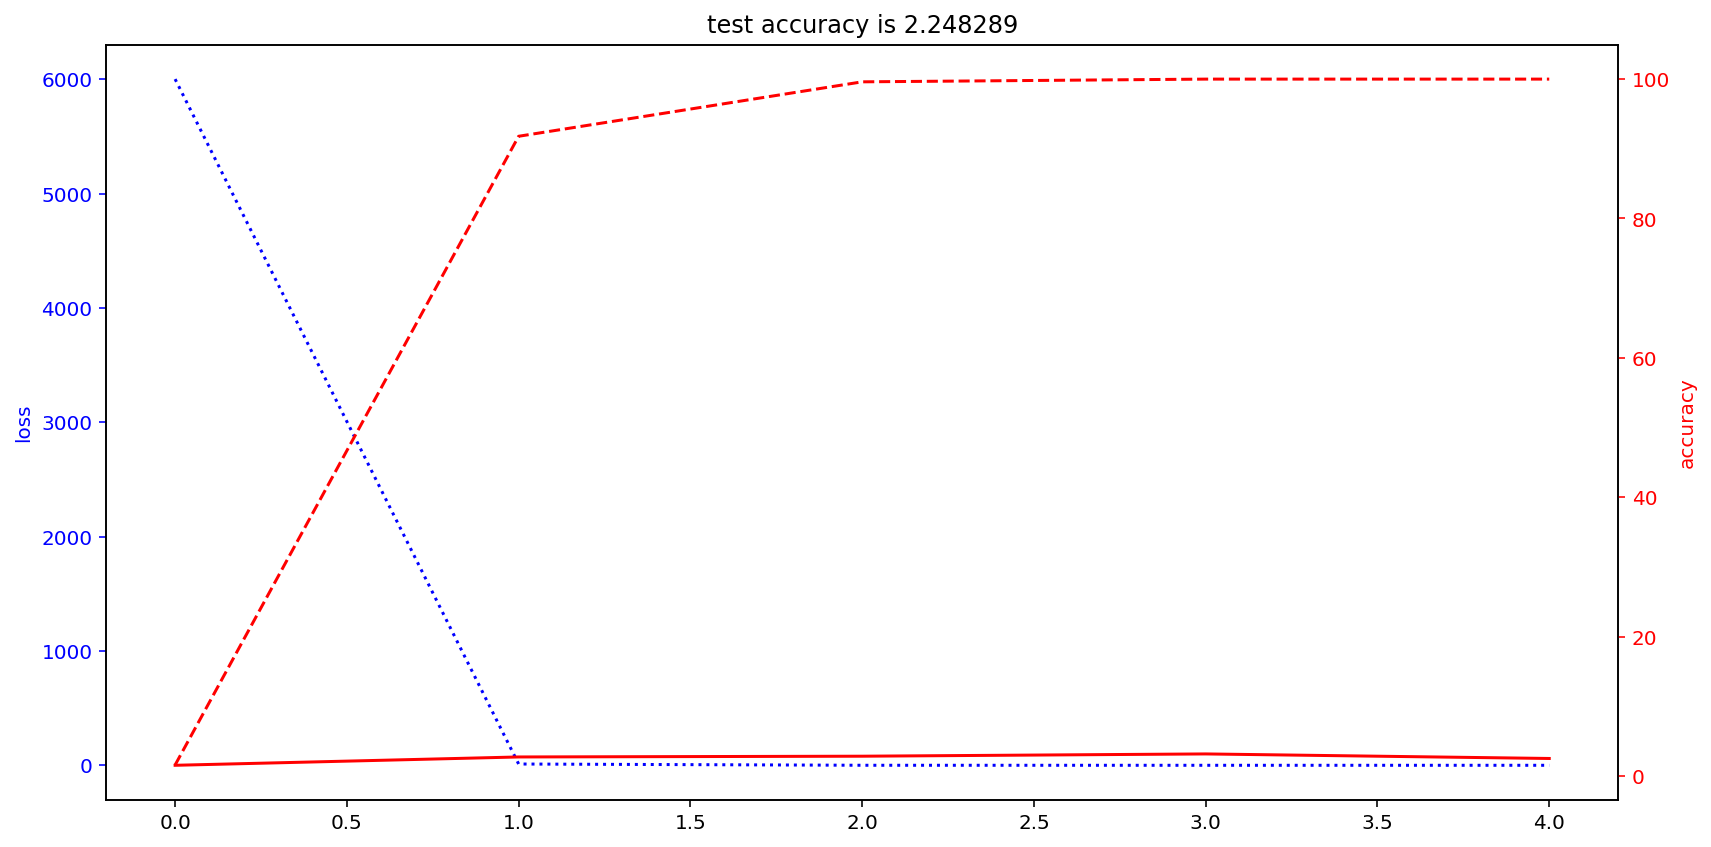

In [63]:
plot_results(losses_1, train_acc_1, valid_acc_1, test_acc_1)

The model is overfitting as the training accuracy going up and the validation accuracy is staying low.

Add regularization to the model

In [85]:
class NN1LR(NN1L):
    def __init__(self, features_size, labels_size, hidden_size, lamb_reg = 0.01):
        
        NN1L.__init__(self, features_size, labels_size, hidden_size)
        
        with self.graph.as_default():
            
            loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.y_train), name="loss")
            regularizers = (tf.nn.l2_loss(self.l1_weights) + 
                            tf.nn.l2_loss(self.l1_biases) + 
                            tf.nn.l2_loss(self.l2_weights) + 
                            tf.nn.l2_loss(self.l2_biases))
            self.loss = loss + lamb_reg * regularizers
            self.optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(self.loss)

In [86]:
nn2 = NN1LR(F_train_scaled.shape[1], l_train.shape[1], 128)

In [87]:
losses_2, train_acc_2, valid_acc_2, test_acc_2 = nn2.run_session(
    'nn_1lr', F_train_scaled, l_train, F_test, l_test, num_epochs = 5000)

Minibatch loss at epoch 0: 80486.992188
Minibatch accuracy: 0.8%
Validation accuracy: 1.3%
Minibatch loss at epoch 1000: 27379.048828
Minibatch accuracy: 91.8%
Validation accuracy: 2.7%
Minibatch loss at epoch 2000: 10069.282227
Minibatch accuracy: 99.6%
Validation accuracy: 2.6%
Minibatch loss at epoch 3000: 3703.356201
Minibatch accuracy: 100.0%
Validation accuracy: 2.7%
Minibatch loss at epoch 4000: 1362.050293
Minibatch accuracy: 100.0%
Validation accuracy: 2.6%


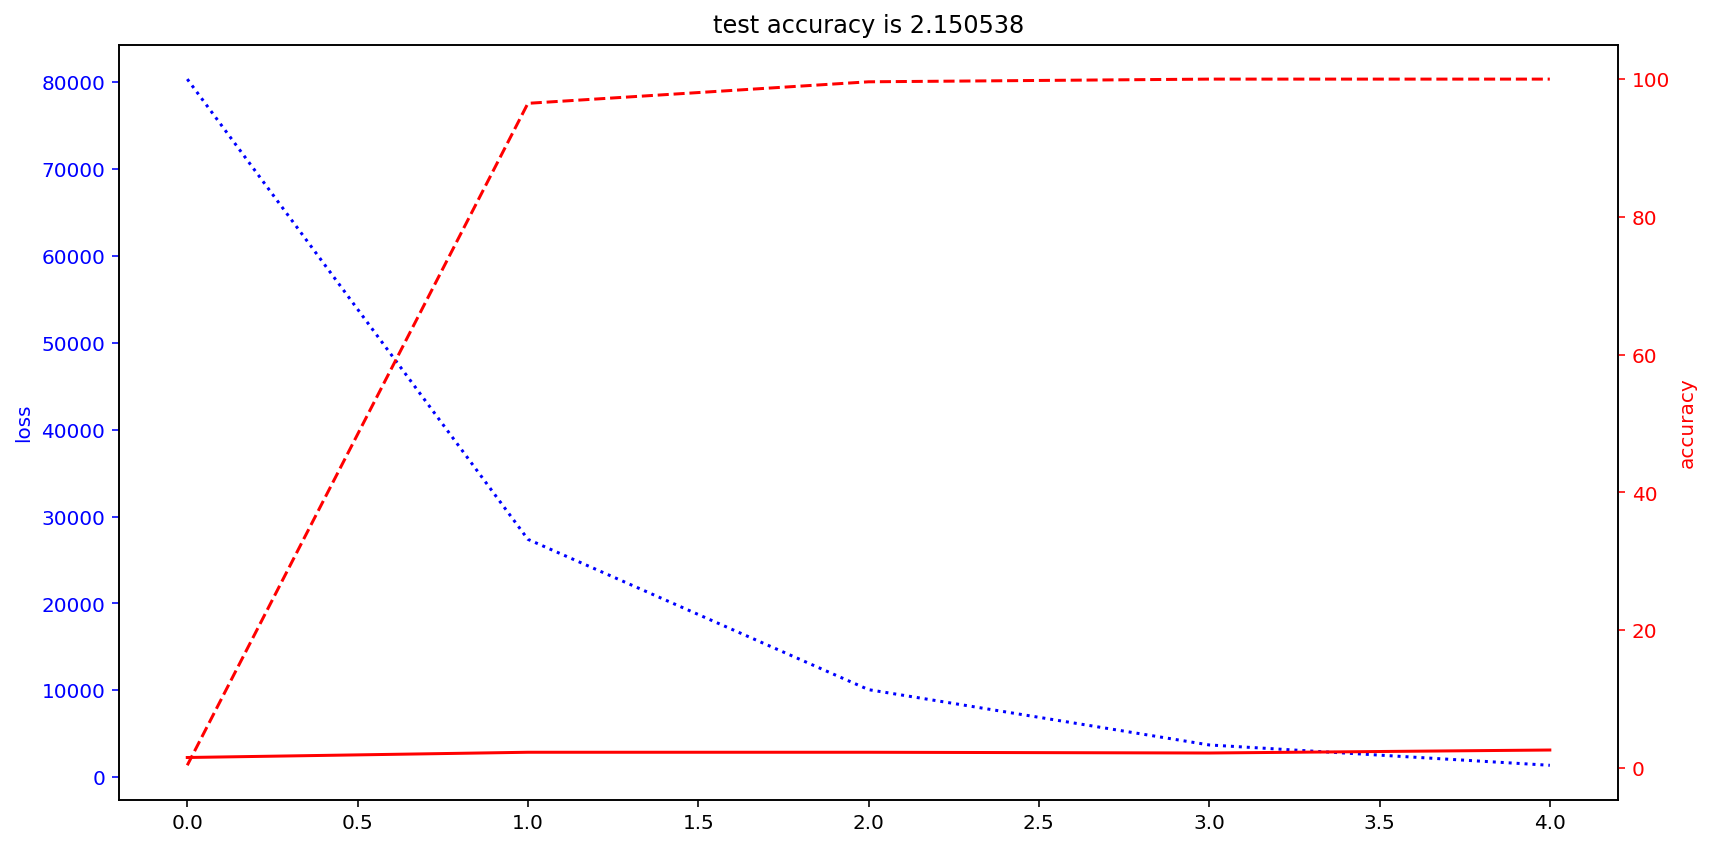

In [29]:
plot_results(losses_2, train_acc_2, valid_acc_2, test_acc_2)

Two layer model

In [92]:
class NN2L(NN):
    def __init__(self, features_size, labels_size, hidden_size1, hidden_size2):

        NN.__init__(self, features_size, labels_size)
        
        with self.graph.as_default():
            with tf.variable_scope("layer1"):
                self.l1_weights, self.l1_biases = self.create_layer([features_size, hidden_size1], [hidden_size1])
            with tf.variable_scope("layer2"):
                self.l2_weights, self.l2_biases = self.create_layer([hidden_size1, hidden_size2], [hidden_size2])
            with tf.variable_scope("layer3"):
                self.l3_weights, self.l3_biases = self.create_layer([hidden_size2, labels_size], [labels_size])
                
            self.logits = self.create_model(self.X_train, name="logits")
            self.train_prediction = tf.nn.softmax(self.logits)
            self.test_prediction =  tf.nn.softmax(self.create_model(self.X_test, name="testing"))
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.y_train), name="loss")
            self.optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(self.loss)

    def create_model(self, data, name):
        with tf.name_scope(name) as scope:
            layer1 = tf.add(tf.matmul(data, self.l1_weights), self.l1_biases, name="layer1")
            hidden1 = tf.nn.relu(layer1, name="relu12")
            layer2 = tf.add(tf.matmul(hidden1, self.l2_weights), self.l2_biases, name="layer2")
            hidden2 = tf.nn.relu(layer2, name="relu23")
            layer3 = tf.add(tf.matmul(hidden2, self.l3_weights), self.l3_biases, name="layer3")
            return layer3

In [ ]:
nn3 = NN2L(F_train_scaled.shape[1], l_train.shape[1], 128, 128)

In [ ]:
losses_3, train_acc_3, valid_acc_3, test_acc_3 = nn3.run_session(
    'nn_2l', F_train_scaled, l_train, F_test, l_test, num_epochs = 10000)

Minibatch loss at epoch 0: 37828.070312
Minibatch accuracy: 1.2%
Validation accuracy: 0.5%
Minibatch loss at epoch 1000: nan
Minibatch accuracy: 1.2%
Validation accuracy: 0.3%
Minibatch loss at epoch 2000: nan
Minibatch accuracy: 0.4%
Validation accuracy: 0.3%
